# ITR 4
#### Ashlynn Wimer

Analyses of the relationship between HOLC grades and modern health outcomes are popular in recent public health literature, with observed relationships between redlining and tbacco retailer density (Schwartz et al., 2021), obstetrics outcomes (Hollenbach et al., 2021), and even time to viral supression of HIV (Bassler et al., 2024). However, only two studies seem to make use of propensity matching approaches: Nardone et al. (2020) and Nardone et al. (2021). Both studies follow a similar approach, in which they match Census Tracts based on their 1940 sociodemographic characteristics, allowing for comparison on their relevant health outcomes (birth outcomes and greenspace, respectively). Both studies additionally find inequitable relationships, with worse HOLC grades resulting in worse modern health outcomes.

However, while Nardone et al. (2020) and Nardone et al. (2021) are methodologically sound, they are theoretically hard to interpret. In particular, we know that HOLC maps were not directly used for loan lending purposes (Markley, 2024), meaning we have no reason to believe that HOLC grades _themselves_ are a cause of worse health outcomes. Instead, a more viable theoretical framework views HOLC maps as potential indicators of racialized ideas about race and space, with Black neighborhoods (or neighborhoods with other racial groups deemed as "underdesirable" being given lower grades) (Markley, 2024). However, Nardone et al. (2020) propensity match on race alongside their other factors, making interpretation of their results more closely tied to (non-)racialized ideas of neighborhoods that are not grappled with in their works. 

In this ITR, we investigate the usage of causal inference methods to "tighten" analysis of the relationship between long-term systemic racism and modern traffic fatalities. In particular, we're interested in using matching approaches to understand three questions:

1. To what extent has a history of systemic racism in New York City, as captured by HOLC maps, led to increased traffic fatalities in modern neighborhoods?

2. To what extent are these disparities -- if any -- attributable to _street network topology?_

3. To what extent are these disparities -- if any -- attributable to _socioeconomic factors?_

We proceed forward using causal language, but acknowledge that our study is not necessarily truly causal due to a century's worth of historical mediators for our results. Nonetheless, we believe our approach tightens the relationships between HOLC and modern health outcomes by controlling for likely causal pathways.  

## A note on language

Throughout this notebook, we will run a causal approach looking at _just_ effects "caused" by worse HOLC gradings, and a causal approach looking at effects which can be tied back to race. For brevity, we will refer to both approaches in our exploration as "causal impacts of redlining," even though -- in a very literal sense -- these are not causal impacts of redlining. 

## Exploration

In [1]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import PowerTransformer, StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
import geopandas as gpd
import pandas as pd
import numpy as np

We construct three sets of treatment/control groups for comparison:

1. A- and B- grade tracts (treatment) versus C- and D- grade tracts (control)

2. A- and B- grade tracts with _no_ noted Black population by the HOLC (treatment) versus C- and D- grade tracts with confirmed Black population by the HOLC (control).

3. C- and D- grade tracts with no HOLC noted Black population (treatment) versus C- and D- grade tracts with confirmed Black population by the HOLC (control).

For each group, we first run a logistic regression to determine the 10 most important factors indicating a tract is part of the treatment, and the 10 most important factors indicating it is part of the control. We then match tracts in our treatment and control group on these values using cosine similarities -- chosen as we have high dimensional data -- and compare traffic outcomes within these groups. 

Importantly, we know that socioeconomic conditions and street topology are mediating factors between systemic racism as indicated by HOLC maps and modern traffic health outcomes. As such, we _also_ run three separate matching approaches:

a. Matching on all data (socioeconomic and graph2vec embeddings)

b. Matching on _just_ socieoconomic data

c. Matching on _just_ graph2vec embeddings.

We understand (b) as an analysis which controls for modern socioeconomic differences, while (c) controls for street topology differences caused by systemic racism. In other words, treatment effect in (b) can be attributed to street topology differences, while differences in (c) can be attributed to socioeconomic factors. (a) is ran predominately for interest, but we additionally understand it as a measure of captured mediators. In particular, if a difference appears in (b) and/or (c) but disappears in (a), then we have likely controlled away the proximal mediating influences of redlining on traffic fatalities outcomes.  

### a: Matching on all data

In [ ]:
### Helper Functions
def pick_relevant_features(data: pd.DataFrame, treatment_var: str, 
                                add_to_drop: list=[], max_iter=10000) -> pd.DataFrame:
    '''
    Use a logistic regression to find the 10 most important features indicating
    that a track received treatment (treatment_var = 1) and the 10 other
    most important indicating that it did not (treatment_var = -1)

    Inputs:
      data (pd.DataFrame): The dataset, containing treatment_var and all columns
        in add_to_drop. It is assumed that all values in the dataset are floats.
      treatment_var (str): The name of the treatment var. Should only
        contain values that are -1 or 1.
      add_to_drop (list[str]): list of additional columns to drop when fitting
        the binary model.

    Returns: pd.Dataframe whose one columns is coefficients and whose index
      are the relevant feature names.
    '''

    # Let's do some feature checking!!
    data = data.copy().dropna(subset=[treatment_var])
    data[treatment_var] = data[treatment_var].astype(int)

    # Train model
    lg = LogisticRegressionCV(max_iter=max_iter)
    lg.fit(data.drop([treatment_var] + add_to_drop, axis=1), data[treatment_var])

    # Coeffs!!
    coefs = pd.DataFrame(lg.coef_[0], index=data.drop([treatment_var] + add_to_drop, axis=1).columns)

    # Select Top 10 most positive + most negative features
    coefs = coefs.sort_values(0, ascending=False)
    coefs = coefs.iloc[[i for i in range(-10, 10)], :]
    return coefs

def match_treatment_control(treatment: pd.DataFrame, 
               control: pd.DataFrame) -> tuple[pd.Series]:
    '''
    Find best matches and match distance in control group for treatment group variables.
    '''
    sim = cosine_similarity(treatment, control)
    best_matches = np.argmax(sim, axis=1)
    match_values = np.max(sim, axis=1)

    return best_matches, match_values

def match_rows(data: pd.DataFrame, features: list[str], 
               treatment_var: str) -> tuple[pd.DataFrame, pd.DataFrame]:
    '''
    Given a DataFrame of data, the features to match on, and the relevant treatment
    variable, return a DataFrame containing matches between treatment variables 
    (treatment_var=1) and control variables (treatment_var=-1) and their similarity
    metrics. Uses cosine_distance.

    Inputs:
      data (pd.Dataframe): DataFrame containing the relevant data. Should have a
        column for all features in features and treatment_var
      features (list[str]): list of strings of the relevant features.
      treatment_var (str): name of treatment variable column. Should be +1 or -1 
        everywhere.

    Returns: tuple[pd.DataFrame, pd.DataFrame]. First DataFrame is the treatment 
      variables from data, with two additional features: 'matches', the index of 
      the best match in the control, and 'similarity', or the similarity for 
      those two matches. Second DataFrame is the control data.  
    '''
    matching = data.loc[:, features]
    treatment = matching.copy()[data[treatment_var] == 1] # A and B grade tracts
    control = matching.copy()[data[treatment_var] == -1] # C and D grade tracts

    metrics, values = match_treatment_control(treatment, control)

    treatment['control_match_index'] = metrics
    treatment['similarity'] = values

    return treatment, control


def assign_race_grade_treatment(row):
    '''
    Assigns tracks to two groups: one if they were A, B graded and held no Black population,
    and another if they were C, D graded and had reported Black population.

    All other tracts are not considered.
    '''
    
    if row.grade in ['A', 'B'] and row.nyn_agg == '0':
        return 1
    
    if row.grade in ['C', 'D'] and row.nyn_agg == '1':
        return -1

    return pd.NA

def assign_cd_white(row):
    '''
    Returns -1 for C/D lined tracts which had reported no Black presence,
    and 1 for C/D lined tracts which had reported black presence.
    '''
    
    if row.grade in ['A', 'B']:
        return pd.NA

    if row.nyn_agg == '1':
        return -1
    
    if row.nyn_agg == '0':
        return 1

    raise ValueError(f'Encountered poorly labeled row {row}')
    
import matplotlib.pyplot as plt

def do_all_matching(data: pd.DataFrame, to_exclude: list=[]
                    ) -> tuple[tuple[pd.DataFrame, pd.DataFrame], 
                               tuple[pd.DataFrame, pd.DataFrame], 
                               tuple[pd.DataFrame, pd.DataFrame]]:
    '''
    Find similarity scores, display a graph of similarity scores, and return all
    relevant treatment/control matching groups. 
    '''
    # Retrieve features, get their names
    coefs_grade = pick_relevant_features(data.drop(to_exclude, axis=1), 'treatment_grade', add_to_drop=['treatment_grade_race', 'cd_white'])
    coefs_grade_race = pick_relevant_features(data.drop(to_exclude, axis=1), 'treatment_grade_race', add_to_drop=['treatment_grade', 'cd_white'])
    coefs_cd = pick_relevant_features(data.drop(to_exclude, axis=1), 'cd_white', add_to_drop=['treatment_grade', 'treatment_grade_race'])

    features_grade = coefs_grade.index
    features_grade_race = coefs_grade_race.index
    features_cd = coefs_cd.index

    import matplotlib.pyplot as plt

    fig, axes = plt.subplots(1, 3, figsize=(20, 10))

    treatment_grade, control_grade = match_rows(data, features_grade, 'treatment_grade')
    treatment_grade_race, control_grade_race = match_rows(data, features_grade_race, 'treatment_grade_race')
    treatment_cd, control_cd = match_rows(data, features_cd, 'cd_white')

    treatment_grade.similarity.plot(kind='kde', ax=axes[0])
    treatment_grade_race.similarity.plot(kind='kde', ax=axes[1])
    treatment_cd.similarity.plot(kind='kde', ax=axes[2])

    axes[0].set_title('AB vs CD')
    axes[1].set_title('AB White vs CD Black')
    axes[2].set_title('CD White vs CD Black')

    plt.show()

    return (treatment_grade, control_grade), (treatment_grade_race, control_grade_race), (treatment_cd, control_cd)

def make_comparisons(treatment: pd.DataFrame, control: pd.DataFrame, 
                        cutoff: float) -> tuple[float, float]:
    '''
    Take treatment and control dataframes and return the difference in car crashes between
    matched tracts with similarity greater than the cutoff.
    '''
    treatment = treatment[treatment.similarity > cutoff]
    control_obs = control.iloc[treatment.control_match_index, :].index

    mean_diff = nyc_data.loc[control_obs].numCrashes.mean() - nyc_data.loc[treatment.index].numCrashes.mean()
    median_diff = nyc_data.loc[control_obs].numCrashes.median() - nyc_data.loc[treatment.index].numCrashes.median()
    
    return mean_diff, median_diff

# data preprocessing
nyc_data = gpd.read_file('./data/shapes/nyc_final.gpkg', arrow=True).dropna()

# Variables for treatment assignment
nyc_data['treatment_grade'] = nyc_data.grade.apply(lambda x: 1 if x in ['A', 'B'] else -1) # HOLC Alone
nyc_data['treatment_grade_race'] = nyc_data[['grade', 'nyn_agg']].apply(assign_race_grade_treatment, axis=1) # HOLC and race
nyc_data['cd_white'] = nyc_data[['grade', 'nyn_agg']].apply(assign_cd_white, axis=1)

nyc_data.set_index('GEOID', inplace=True)

data = nyc_data.copy()\
    .drop(['unempl', 'HRI2010', 'grade', 'nyn_agg', 'geometry'], axis=1)

pt = PowerTransformer()
ss = StandardScaler()

data['numCrashes'] = pt.fit_transform(data[['numCrashes']])
data.loc[:, ~data.columns.isin(['numCrashes', 'treatment_grade', 'treatment_grade_race', 'cd_white'])] \
    = ss.fit_transform(data.drop(['numCrashes', 'treatment_grade', 'treatment_grade_race', 'cd_white'], axis=1))


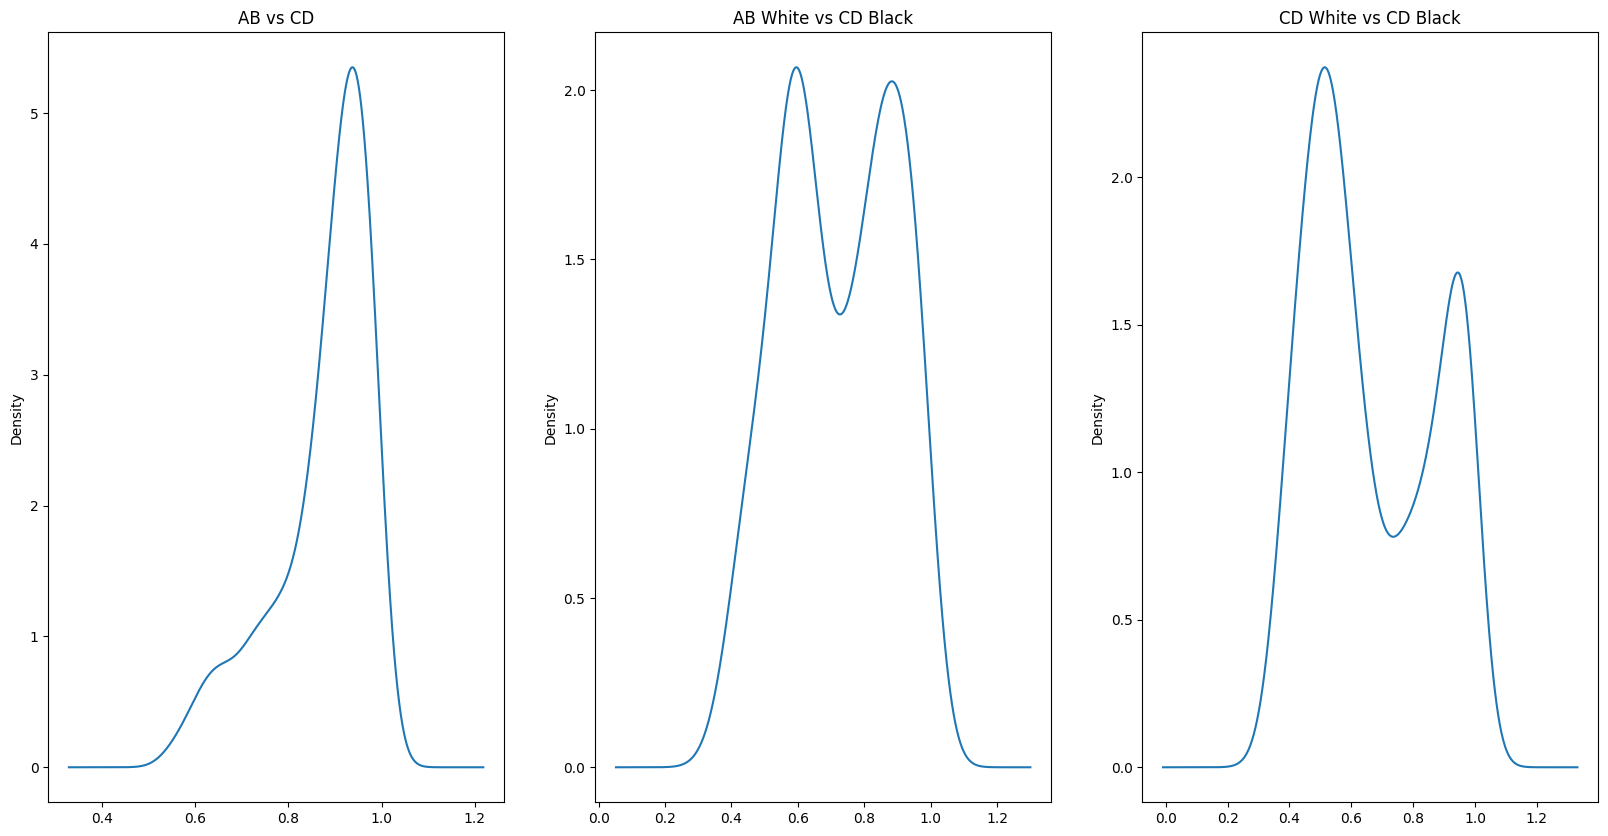

In [3]:
(treatment_grade, control_grade), (treatment_grade_race, control_grade_race), (treatment_cd, control_cd) = do_all_matching(data)

Based on these graphs, .8 is a reasonable cutoff for AB vs CD. AB White vs CD Black and CD White vs CD Black both display poor matching, with two bimodal distributions. Below, we cutoff in the valley (.7 vs the former and .8 for the latter), but note that observed disparities increase when as we use a lower cutoff score, indicating that we are potentially controlling for the most relevant differences in these two cases.

A: **AB Grade vs CD Grade**:

In [4]:
make_comparisons(treatment_grade, control_grade, .7)

(4.972727272727273, 5.0)

In [5]:
make_comparisons(treatment_grade, control_grade, .8)

(4.291666666666664, 4.0)

In [6]:
make_comparisons(treatment_grade, control_grade, .9)

(3.379487179487178, 4.0)

B: **AB White vs CD Black**:

In [7]:
make_comparisons(treatment_grade_race, control_grade_race, .6)

(2.581818181818182, 1.0)

In [8]:
make_comparisons(treatment_grade_race, control_grade_race, .7)

(2.254545454545454, 1.0)

In [9]:
make_comparisons(treatment_grade_race, control_grade_race, .8)

(1.1111111111111143, -1.5)

C: **CD White vs CD Black**:

In [10]:
make_comparisons(treatment_cd, control_cd, .7)

(3.019390581717449, 2.0)

In [11]:
make_comparisons(treatment_cd, control_cd, .8)

(3.4662162162162176, 2.0)

In [12]:
make_comparisons(treatment_cd, control_cd, .9)

(3.808080808080806, 1.5)

Overall, we find decreased effect sizes as we have more stringent matching comparisons, with cases (B) and (C) having smaller effects than (A). However, the matches in (B) and (C) are worse than those in (A), indicating that the variables we are matching on may be controlling our outcomes. 

### b: Matching on socioeconomic data

Notably, in this case our decision to use cosine similarity is least appropriate, as we are in relatively low-dimension. Regardless, we continue with cosine similarity as our measure for consistency:

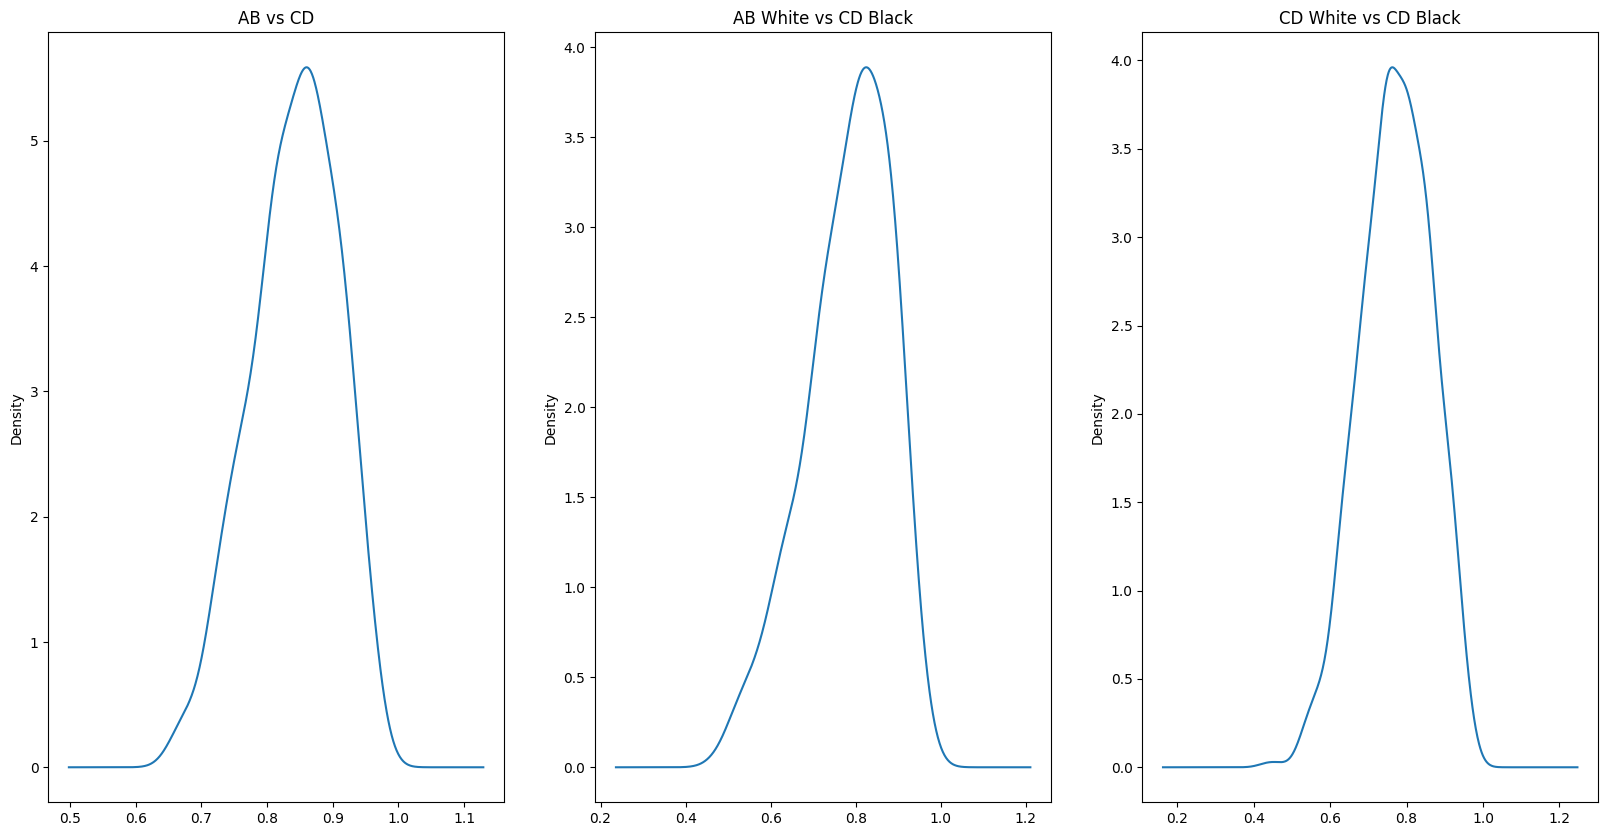

In [13]:
GRAPH_VARIABLES = [f"embed{i}" for i in range(128)]

(treatment_grade, control_grade), (treatment_grade_race, control_grade_race), (treatment_cd, control_cd) = do_all_matching(data, GRAPH_VARIABLES)

.7, .7, and .6 are contestable but likely viable cuttoffs. We also test +/- .1 of these values:

A: **AB Grade vs CD Grade**:

In [14]:
make_comparisons(treatment_grade, control_grade, .6)

(1.920547945205481, 1.0)

In [15]:
make_comparisons(treatment_grade, control_grade, .7)

(1.899159663865543, 1.0)

In [16]:
make_comparisons(treatment_grade, control_grade, .8)

(2.0811808118081174, 2.0)

B: **AB White vs CD Black**:

In [17]:
make_comparisons(treatment_grade_race, control_grade_race, .6)

(3.73063973063973, 4.0)

In [18]:
make_comparisons(treatment_grade_race, control_grade_race, .7)

(4.079365079365079, 4.0)

In [19]:
make_comparisons(treatment_grade_race, control_grade_race, .8)

(4.583333333333336, 6.5)


C: **CD White vs CD Black**:

In [20]:
make_comparisons(treatment_cd, control_cd, .5)

(2.4759825327510896, 2.0)

In [21]:
make_comparisons(treatment_cd, control_cd, .6)

(2.573844419391204, 2.0)

In [22]:
make_comparisons(treatment_cd, control_cd, .7)

(2.3757062146892665, 1.0)

(A) and (C) both stay relatiely consistent as we change our metrics, but (B) is sensitive to changes.

### c: Matching on street networks

We now return to a realm where cosine similarity makes sense! 

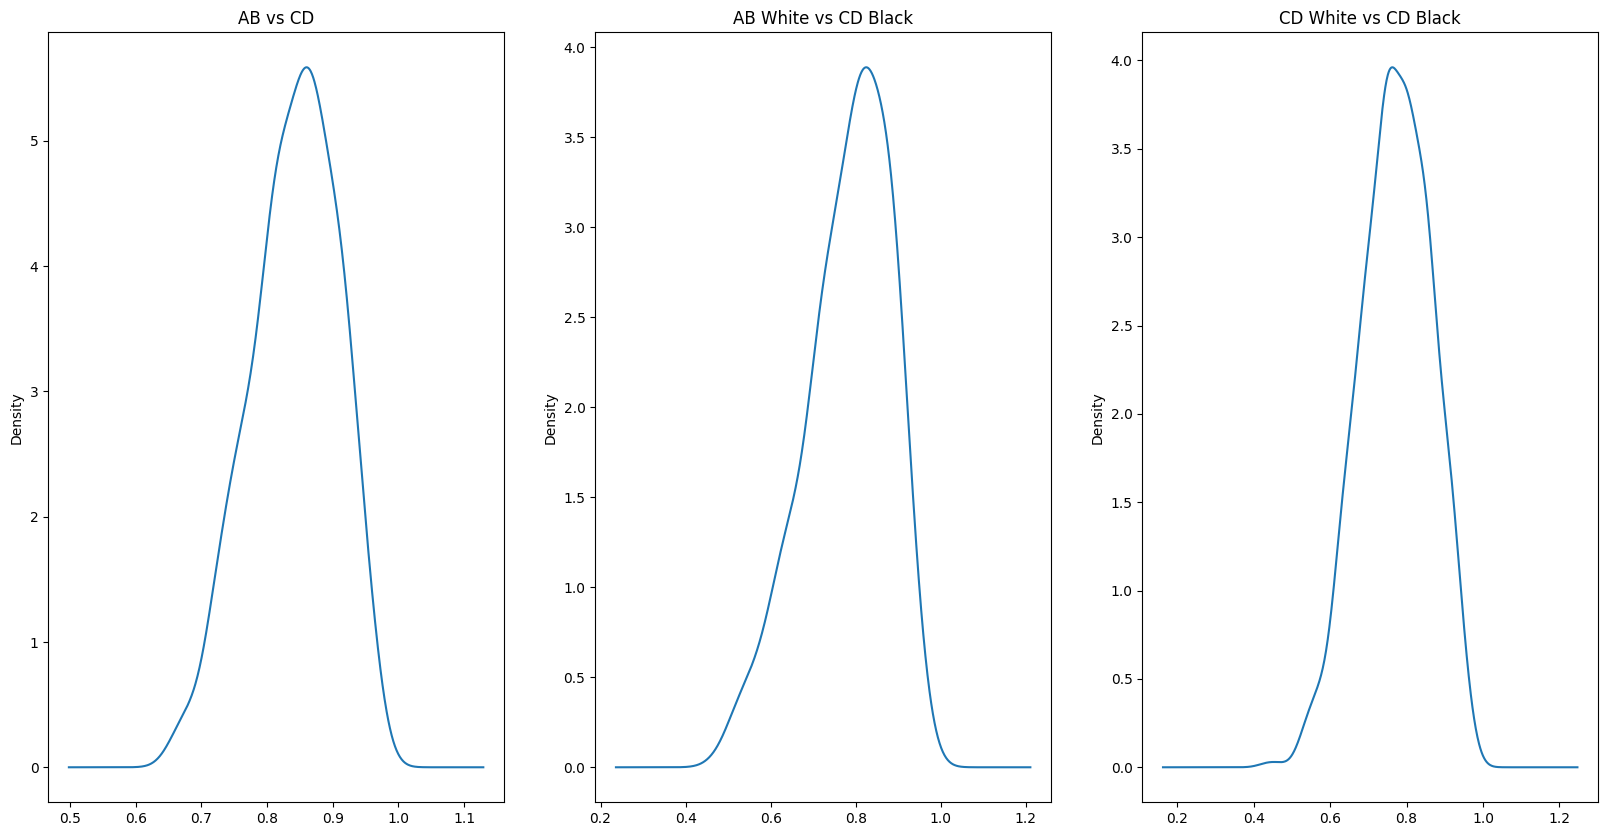

In [23]:
GRAPH_VARIABLES = [f"embed{i}" for i in range(128)]
to_exclude = [col for col in data.columns if col in GRAPH_VARIABLES]

(treatment_grade, control_grade), (treatment_grade_race, control_grade_race), (treatment_cd, control_cd) = do_all_matching(data, to_exclude)

.7, .6, and .65 are our best (but contentious) cuts:

A: **AB Grade vs CD Grade**:

In [24]:
make_comparisons(treatment_grade, control_grade, .6)

(1.920547945205481, 1.0)

In [25]:
make_comparisons(treatment_grade, control_grade, .7)

(1.899159663865543, 1.0)

In [26]:
make_comparisons(treatment_grade, control_grade, .8)

(2.0811808118081174, 2.0)

B: **AB White vs CD Black**:

In [27]:
make_comparisons(treatment_grade_race, control_grade_race, .5)

(3.964968152866245, 4.0)

In [28]:
make_comparisons(treatment_grade_race, control_grade_race, .6)

(3.73063973063973, 4.0)

In [29]:
make_comparisons(treatment_grade_race, control_grade_race, .7)

(4.079365079365079, 4.0)

C: **CD White vs CD Black**:

In [33]:
make_comparisons(treatment_cd, control_grade_race, .55)

(2.5198237885462547, 2.0)

In [31]:
make_comparisons(treatment_cd, control_cd, .65)

(2.40609756097561, 2.0)

In [34]:
make_comparisons(treatment_cd, control_grade_race, .75)

(2.4692028985507264, 1.0)

(A), (B), and (C) all seem robust to changes in cutoff.

# Reflect

In the above analysis, we have attempted to better understand the causal influence of historic redlining policies on modern day health outcomes, conducting a suite of matching approaches on three different treatment/control splits. We consider our results for each matching approach separately:

**AB- Grade vs CD- Grade**: 

In this case, we found that lower graded census tracts generally had larger numbers of traffic crashes. The effect seems to be equally indicated by socioeconomic factors as it is by street network topology. The general difference between AB- and CD- grade tracts is likely influenced in part by race, but (based on other studies and our own results), it may not be entirely driven by systemic racism, leading to the potential for theory explaining non-racial associations between low HOLC grades and worse health outcomes.

**AB- Grade Non-Black vs CD- Grade Black**:

In this case, we generally found that CD- Graded tracts with Black populations had worse outcomes than AB- Grade tracts without black populations reported by HOLC, although the results are complicated. In particular, matching between these two groups across all variables is challenging, with the resultant similarity distribution being bimodal. This may indicate that the socioeconomic and street network topology differences between our groups are so dramatic in this case that matching approaches are inappropriate across the entire dataset. Nonetheless, we find dramatic differences between these two groups when only matching on socioeconomic or street topology alone, indicating that there is likely a strong causal impact of long-run systemic racism on traffic outcomes. 

**CD- Grade Non-Black vs CD- Grade Black**:

We matched CD- Graded Non-Black and CD- Graded Black census tracts, finding that the latter category tended to have more traffic crashes than the former. We observe approximately equal differences in all cases, indicating that they may be equally due to street network topology as to socioeconomic factors. Notably, while the shared grading of these tracts may lead one to believe they would always match well, the similarity distribution in the all-variables case was bimodal, indicating some level of mismatch based on race alone.

Taken altogether, we have evidence that not only does lower HOLC grade indicate worse traffic health outcomes, but that these disparities are larger when accounting for the influence of systemic racism. Importantly, we found that street network topology is a driving force behind these disparities. Street networks develop over the course of decades -- particularly in large cities such as NYC -- further emphasizing the far reaching hand of systemic racism in determining modern traffic health outcomes.

While our analysis of CD- Grade tracts hints that race is a driving fundamental cause of these disparities, we also found evidence in our AB- Grade vs CD- Grade analysis that there may be non-race-based pathways captured by HOLC grading that are worth exploring (or refuting) in future analyses.

# Bibliography

Bassler, J. R., Ostrenga, L., Levitan, E. B., Kay, E. S., Long, D. M., Mugavero, M. J., Nassel, A. F., Parman, M., Tate, M., Rana, A., & Batey, D. S. (2024). Redlining and Time to Viral Suppression Among Persons With HIV. JAMA Internal Medicine, 184(11), 1329–1337. https://doi.org/10.1001/jamainternmed.2024.5003

Hollenbach, S. J., Thornburg, L. L., Glantz, J. C., & Hill, E. (2021). Associations Between Historically Redlined Districts and Racial Disparities in Current Obstetric Outcomes. JAMA Network Open, 4(9), e2126707. https://doi.org/10.1001/jamanetworkopen.2021.26707

Markley, S. (2024). Federal ‘redlining’ maps: A critical reappraisal. Urban Studies, 61(2), 195–213. https://doi.org/10.1177/00420980231182336

Nardone, A. L., Casey, J. A., Rudolph, K. E., Karasek, D., Mujahid, M., & Morello-Frosch, R. (2020). Associations between historical redlining and birth outcomes from 2006 through 2015 in California. PLOS ONE, 15(8), e0237241. https://doi.org/10.1371/journal.pone.0237241

Nardone, A., Rudolph, K. E., Morello-Frosch, R., & Casey, J. A. (2021). Redlines and Greenspace: The Relationship between Historical Redlining and 2010 Greenspace across the United States. Environmental Health Perspectives, 129(1), 017006. https://doi.org/10.1289/EHP7495

Schwartz, E., Onnen, N., Craigmile, P. F., & Roberts, M. E. (2021). The legacy of redlining: Associations between historical neighborhood mapping and contemporary tobacco retailer density in Ohio. Health & Place, 68, 102529. https://doi.org/10.1016/j.healthplace.2021.102529
